In [1]:
import os
import json
import matplotlib.pyplot as plt

In [105]:
# Collect organizations and their co-occurences

dir = 'json/'; files = os.listdir(dir)
orgs = []; texts = []

for index, filename in enumerate(files):
    
    f = open(dir + filename)
    r = f.read()
    parsed = json.loads(r)
    tags = parsed[0]['story_tags']
    
    # Remove excessive values
    if len(tags) > 1000:
        continue

    names = []

    for tag in tags:
        if (tag['tag_set'] == 'cliff_organizations'):
            names.append(tag['tag'])

    
    # string = str(names)

    for name in names:
        if name in orgs:
            index = orgs.index(name)
            texts[index] = texts[index] + names
        else:
            orgs.append(name)
            texts.append(names)

# Clean less citates organizations

min = 500

for index, text in reversed(list(enumerate(texts))):

    if len(text) < min:
        orgs.pop(index)
        texts.pop(index)
    # else:
        # print()
        # print(index, len(text))
        # print(orgs[index])


print('# texts', len(texts), '# orgs', len(orgs))


# texts 107 # orgs 107


In [106]:
# Term Frequency Matrix

doc_term_matrix, dictionary = textacy.representations.build_doc_term_matrix(texts, tf_type="linear", idf_type="smooth")


 * creating mesh with size 33 33
 * filling mesh


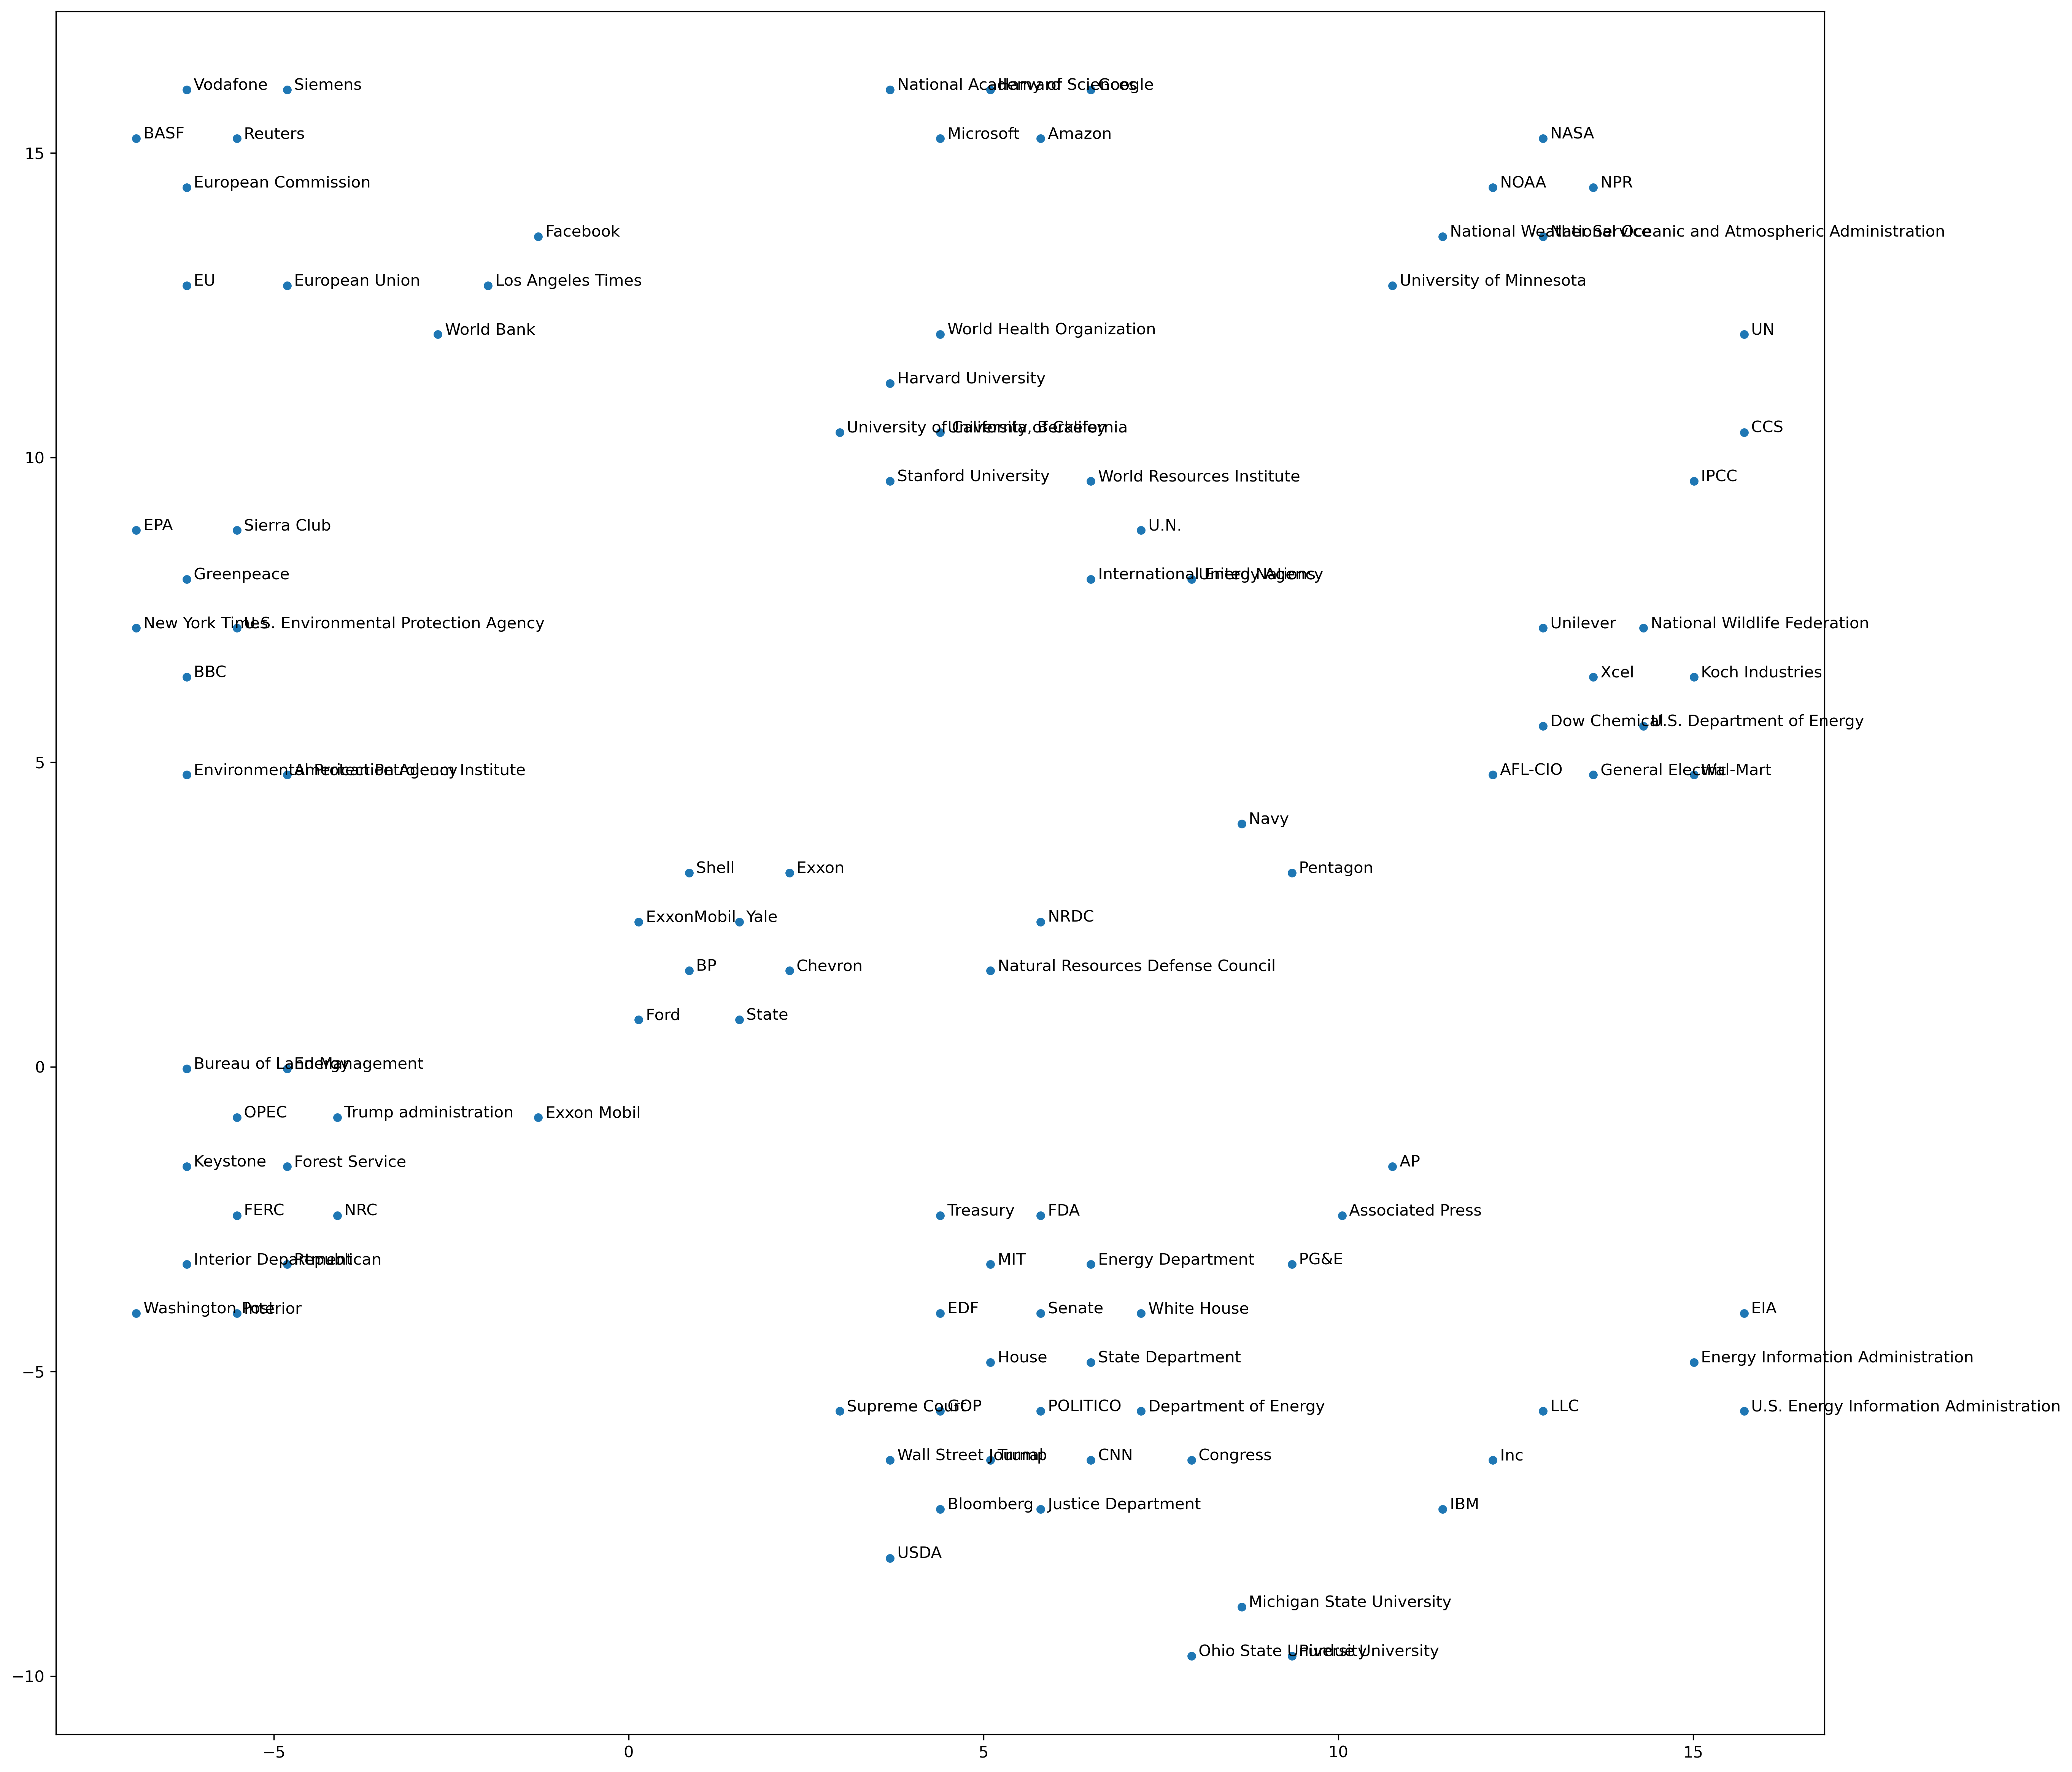

In [107]:
# UMAP

import umap
import matplotlib.pyplot as plt
from pointgrid import align_points_to_grid


reducer = umap.UMAP(n_components=2, n_neighbors=2, min_dist=0.01, metric='cosine')
# reducer = umap.UMAP(random_state=2, n_components=2, n_neighbors=2, min_dist=0.01, metric='hellinger')

embedding = reducer.fit_transform(doc_term_matrix)
embedding = align_points_to_grid(embedding)

x = embedding[:, 0]; y = embedding[:, 1]

plt.figure(figsize=(20,20), dpi=300)
plt.scatter(x, y, s=20)

for i, txt in enumerate(orgs):
    text = plt.annotate(' ' + orgs[i], (x[i] + .03, y[i]))
    text.set_fontsize(10)